# Title
Author: Tom Chapman

## Business Understanding
Since their inception, online marketplaces have fundamentally shifted how consumers shop. With a near limitless number of products and services available online, it has never been less important for a consumer to walk into a brick-and-mortar store to make a purchase. However, identifying which products or services are high-quality has become increasingly difficult. The popularity of the 5-star rating scale has led to a number of well-documented challenges. [Harvard Business Review](https://hbr.org/2019/07/the-problems-with-5-star-rating-systems-and-how-to-fix-them) summed these challenges up nicely as follows:

- There is little incentive for consumers to provide truthful feedback, meaning that extreme experiences (whether positive or negative) are much more likely to lead a consumer to leave a review.
- Compounding the lack of incentive for truth, 5-star ratings are prone to grade inflation. There is no correlation between the star-rating and the sentiment the user expresses in a review. It's possible (and surprisingly common) for a user to hate a product, excorriate it in a review, and then rate it 5-stars. This leads to inflated ratings, and makes it harder for the consumer to understand the review variance between products.

My tool is intended to help address rating inflation by classifying user feedback as positive or negative based on its content. I also prioritized ease-of-implementation by limiting model size and complexity wherever possible. I want this tool to be accessible to sellers without significant compute resources, so it needs to function well on a large dataset AND be runnable on a single machine. I used natural language processing for this project, AND IMPLEMENTED A TOOL CAPABLE OF INGESTING USER REVIEWS FROM XXXX 

Amazon is the largest online marketplace currently in existence, and its challenges with rating inflation are well-documented. My tool could be useful to help reclassify ratings based on their sentiment for Amazon itself. It is also useful for sellers that want to move away from Amazon or implement their own storefront. By implementing my algorithm in a newly-created storefront, sellers can better classify consumer feedback and derive a more accurate understanding of how their products or services are being received.





## Data Preparation



In [15]:
# Package Imports
import pandas as pd
import numpy as np
import pickle

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, make_scorer, recall_score, accuracy_score, precision_score, f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, cross_validate, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

from imblearn.pipeline import Pipeline as ImPipeline

import warnings
warnings.filterwarnings('ignore')

# Modeling
I utilized a number of sklearn's modeling techniques for the project, and performed grid searches to optimize the hyperparameters of the best-performing model. As noted in the data-preparation description, I experimented with the inclusion of bi-grams and tri-grams created from user input during the modeling process as well. Ultimately...

In [2]:
# Read in the data
df = pd.read_csv('../data/train_cleaned_10sw.csv', index_col=0)

In [3]:
df.head()

,sentiment,text,text_cleaned,toks,bigrams,trigrams
0,2,This sound track was beautiful! It paints the ...,sound track beautiful paint senery mind well w...,"['sound', 'track', 'beautiful', 'paint', 'sene...","[('sound', 'track'), ('track', 'beautiful'), (...","[('sound', 'track', 'beautiful'), ('track', 'b..."
1,2,I'm reading a lot of reviews saying that this ...,i'm reading lot review say best game soundtrac...,"[""i'm"", 'reading', 'lot', 'review', 'say', 'be...","[(""i'm"", 'reading'), ('reading', 'lot'), ('lot...","[(""i'm"", 'reading', 'lot'), ('reading', 'lot',..."
2,2,This soundtrack is my favorite music of all ti...,soundtrack favorite music time hand intense sa...,"['soundtrack', 'favorite', 'music', 'time', 'h...","[('soundtrack', 'favorite'), ('favorite', 'mus...","[('soundtrack', 'favorite', 'music'), ('favori..."
3,2,I truly like this soundtrack and I enjoy video...,truly soundtrack enjoy video game music play g...,"['truly', 'soundtrack', 'enjoy', 'video', 'gam...","[('truly', 'soundtrack'), ('soundtrack', 'enjo...","[('truly', 'soundtrack', 'enjoy'), ('soundtrac..."
4,2,"If you've played the game, you know how divine...",played game know divine music every single son...,"['played', 'game', 'know', 'divine', 'music', ...","[('played', 'game'), ('game', 'know'), ('know'...","[('played', 'game', 'know'), ('game', 'know', ..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3600000 entries, 0 to 3599999
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   sentiment     int64 
 1   text          object
 2   text_cleaned  object
 3   toks          object
 4   bigrams       object
 5   trigrams      object
dtypes: int64(1), object(5)
memory usage: 192.3+ MB


In [17]:
df['sentiment'].value_counts()

1    1799993
2    1799984
Name: sentiment, dtype: int64

In [5]:
max_features = None

In [6]:
print(df.isna().sum())
df[df['text_cleaned'].isna()]

sentiment        0
text             0
text_cleaned    23
toks             0
bigrams          0
trigrams         0
dtype: int64


,sentiment,text,text_cleaned,toks,bigrams,trigrams
217919,2,ò ñàìà ì áèìà ñí è íí ñàìé áèìé äèñ . ß ìíäó ñ...,NaN,[],[],[]
294435,2,............ ..... ..... ...... ...... ..........,NaN,[],[],[]
556297,2,it's very good ... .... ... ... ... ... ... .....,NaN,[],[],[]
629878,1,...............................,NaN,[],[],[]
680354,2,ò äèí è ñàì ìè áèì ìèò. à ò ññèè èàò ìà èäàò ä...,NaN,[],[],[]
1440939,1,|||||||||||||||||||| |||||||||| ||||||||||||||...,NaN,[],[],[]
1786231,2,38493 34740 47383 37054 48624 78568? 18581 286...,NaN,[],[],[]
1989004,2,&#4315;&#4304;&#4306;&#4304;&#4320;&#4312;&#43...,NaN,[],[],[]
2005370,1,&#1575;&#1606;&#1578;&#1605; &#1594;&#1610;&#1...,NaN,[],[],[]
2071299,2,&#1042;&#1089;&#1077; &#1087;&#1088;&#1080;&#1...,NaN,[],[],[]


In [7]:
# Drop rows with missing text_cleaned values
df.dropna(inplace=True)

In [11]:
# Save off feature combinations for use in model iteration
X = df['text_cleaned']

X_bigrams = df[['text_cleaned', 'bigrams']]
X_trigrams = df[['text_cleaned', 'trigrams']]
X_allgrams = df[['text_cleaned', 'bigrams', 'trigrams']]

y = df['sentiment']

### Dummy Classifier
To begin modelling efforts, I built a dummy classifier that simply guesses the most common class every time. Given that our training data is almost (but not perfectly) balanced, we should expect it to predict that every review is negative since there are slightly more negative reviews than positive reviews. If we can't beat a 50-50 guess with a dataset this large, something is horribly wrong. Predictably, the dummy classifier achieved an accuracy score of almost exactly 50%.

In [12]:
# Instantiate Dummy Classifier pipeline
dummy_pipe = ImPipeline(steps=[
                                ('vect', TfidfVectorizer(max_features=max_features)),
                                ('dc', DummyClassifier(strategy='most_frequent',
                                                           random_state=42))
                              ]
)

0.5000012500079861


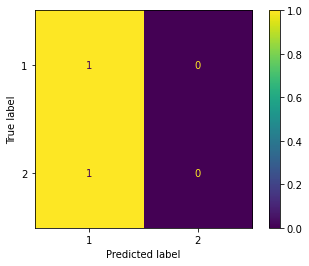

In [16]:
# Fit dummy pipe on the training data and plot confusion matrix
dummy_pipe.fit(X, y)
dummy_yhat = dummy_pipe.predict(X)
plot_confusion_matrix(dummy_pipe, X, y, normalize='true');
print(accuracy_score(y, dummy_yhat))

### Multinomial Naive Bayes
MNB is a commonly-used algorithm for natural language processing due to effectiveness in classifying topics while maintaining a low training time and relative simplicity. It predicts the probability that a given document belongs to a particular class based on the words it contains. I employed a multinomial naive bayes classifier as my first simple model for these reasons. 

0.8284569595861306


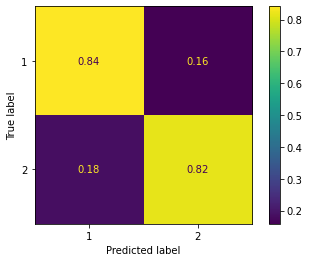

In [18]:
# Instantiate the Multinomial Naieve Bayes Pipeline
mnb_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer(max_features=max_features)),
                            ('mnb', MultinomialNB())
                            ]
)

# Fit MNB pipe on the training data, get predictions and plot confusion matrix
mnb_pipe.fit(X_bigrams, y)
mnb_yhat = mnb_pipe.predict(X_bigrams)
plot_confusion_matrix(mnb_pipe, X, y, normalize='true');
print(accuracy_score(y, mnb_yhat))

In [19]:
mnb_pipe.named_steps['mnb'].n_features_
#__mnb.n_features_

821050

In [20]:
# Obtained cross-validated accuracy score
cross_validate(mnb_pipe, X, y)

{'fit_time': array([63.91176295, 64.27754903, 63.07658076, 62.96271181, 63.14784789]),
 'score_time': array([14.80177712, 14.56706309, 14.5999763 , 14.49988723, 14.33135796]),
 'test_score': array([0.81850038, 0.81476842, 0.81272648, 0.81008618, 0.81112924])}

- 'fit_time': 63.91176295, 64.27754903, 63.07658076, 62.96271181, 63.14784789
- 'score_time': 14.80177712, 14.56706309, 14.5999763 , 14.49988723, 14.33135796
- 'test_score': 0.81850038, 0.81476842, 0.81272648, 0.81008618, 0.81112924

#### Using N-grams as Features
To see if I could improve on the model's performance over using single words, I tried giving it bi-grams and tri-grams as additional features. Ultimately XXXX

In [ ]:
# Instantiate the Multinomial Naieve Bayes Pipeline
mnb_bigrams_pipe = ImPipeline(steps=[
                                    ('vect', TfidfVectorizer(max_features=max_features)),
                                    ('mnb', MultinomialNB())
                                    ]
)

# Fit MNB pipe on the training data, get predictions and plot confusion matrix
mnb_pipe.fit(X_grams, y)
mnb_yhat = mnb_pipe.predict(X_grams)
plot_confusion_matrix(mnb_pipe, X_grams, y, normalize='true');
print(accuracy_score(y, mnb_yhat))

### Stochastic Gradient Descent Classifier
Stochastic gradient descent is another technique that is very common in natural language processing due to its efficiency. Rather than calculating the gradient at each iteration using every observation, it selects one observation at random for each step, drastically reducing the computational requirements. It also works very well with sparse data, which makes it a natural fit for NLP. Given the size of my dataset, SGD was a natural next step and XXXX...

In [ ]:
# Instantiate the SGDC Classifier pipeline
sgdc_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer(max_features=max_features,
                                                    #max_df=0.95,
                                                   # min_df=0.05
                                                    )),
                            ('sgdc', SGDClassifier(random_state=42))
                            ]
)

#Fit SGDC pipe on the training data, get predictions and plot confusion matrix
sgdc_pipe.fit(X, y)
sgdc_yhat = sgdc_pipe.predict(X)
plot_confusion_matrix(sgdc_pipe, X, y, normalize='true');
print(accuracy_score(y, sgdc_yhat))

In [ ]:
# Obtained cross-validated accuracy score
# cross_validate(sgdc_pipe, X, y)

In [ ]:
sgdc_params = {
            'sgdc__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 0.0002, 0.0005],
            #'sgdc__n_iter': [50, 100, 500],
            'sgdc__loss': ['hinge', 'log', 'huber'],
            'sgdc__penalty': ['l2', 'l1', 'elasticnet'],
            'vect__max_features': [None, 50000, 100000, 200000]
             }

In [ ]:
#sgdc_gs = GridSearchCV(sgdc_pipe, param_grid=sgdc_params, n_jobs=-2, verbose=3, cv=3)
#sgdc_gs.fit(X, y)

In [ ]:
sgdc_gs.best_params_

In [ ]:
# Instantiate the SDGC Classifier pipeline
sgdc_tuned_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer(max_features=50000,
                                                    #max_df=0.95,
                                                   # min_df=0.05
                                                    )),
                            ('sgdc', SGDClassifier(random_state=42,
                                                  alpha=0.0001,
                                                  loss = 'hinge',
                                                  penalty='l2'
                                                  ))
                            ]
)

#Fit SGDC pipe on the training data, get predictions and plot confusion matrix
sgdc_tuned_pipe.fit(X, y)
sgdc_tuned_yhat = sgdc_tuned_pipe.predict(X)
plot_confusion_matrix(sgdc_tuned_pipe, X, y, normalize='true');
print(accuracy_score(y, sgdc_tuned_yhat))

In [ ]:
# Obtained cross-validated accuracy score
cross_validate(sgdc_pipe, X_grams, y)

In [ ]:
with open ('sgdc_pkl', 'wb') as files:
    pickle.dump(sgdc_tuned_pipe, files)

#### Using N-grams as Features 
To see if I could improve on the model's performance over using single words, I tried giving it bi-grams and tri-grams as additional features. Ultimately XXXX

In [ ]:
# Instantiate the SGDC Classifier pipeline
sgdc_ngrams_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer(max_features=max_features,
                                                    #max_df=0.95,
                                                   # min_df=0.05
                                                    )),
                            ('sgdc', SGDClassifier(random_state=42))
                            ]
)

#Fit SGDC pipe on the training data, get predictions and plot confusion matrix
sgdc_ngrams_pipe.fit(X_grams, y)
sgdc_ngrams_yhat = sgdc_ngrams_pipe.predict(X_grams)
plot_confusion_matrix(sgdc_ngrams_pipe, X_grams, y, normalize='true');
print(accuracy_score(y, sgdc_ngrams_yhat))

In [ ]:
# Obtained cross-validated accuracy score
cross_validate(sgdc_pipe, X_grams, y)

### Random Forest Classifier

In [ ]:
# Instantiate the Random Forest Pipeline
rf_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer(max_features=max_features)),
                            ('rf', RandomForestClassifier())
                            ]
)

# Fit RF pipe on the training data, get predictions and plot confusion matrix
# rf_pipe.fit(X, y)
rf_yhat = rf_pipe.predict(X)
plot_confusion_matrix(rf_pipe, X, y);
print(accuracy_score(y, rf_yhat))

In [ ]:
# Obtained cross-validated accuracy score
# cross_validate(rf_pipe, X, y)

In [ ]:
with open ('rf_pkl', 'wb') as files:
    pickle.dump(rf_pipe, files)

### Gradient Boosting Classifier

In [ ]:
# Instantiate the gradient boosting classifier pipeline
gbc_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('gbc',  GradientBoostingClassifier())
                                ]
)

#Fit SGDC pipe on the training data, get predictions and plot confusion matrix
gbc_pipe.fit(X, y)
gbc_yhat = gbc_pipe.predict(X)
plot_confusion_matrix(gbc_pipe, X, y);
print(accuracy_score(y, gbc_yhat))

In [ ]:
# Obtained cross-validated accuracy score
cross_validate(gbc_pipe, X, y)

In [ ]:
# Instantiate the gradient boosting classifier pipeline
gbc_ngrams_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('gbc',  GradientBoostingClassifier())
                                ]
)

#Fit SGDC pipe on the training data, get predictions and plot confusion matrix
gbc_ngrams_pipe.fit(X_grams, y)
gbc_ngrams_yhat = gbc_ngrams_pipe.predict(X_grams)
plot_confusion_matrix(gbc_ngrams_pipe, X_grams, y);
print(accuracy_score(y, gbc_yhat))

In [ ]:
# Obtained cross-validated accuracy score
cross_validate(gbc_pipe, X_grams, y)

## Final Model Evaluation
The XXXX model ended up performing best on the test data, so I selected it as the appropriate model to deploy. 

- Score
- what did it do well
- what are its shortcomings
- how well does it solve the business problem?